In [1]:
import sys, os, re, random, warnings, pickle
sys.path.append(os.path.dirname(os.getcwd()))
from config import *

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F

from ss_inference.model import NetSurfP2, ConvNet

from utils import *
from ssqa import *
from data import *
from pgm import *


warnings.filterwarnings("ignore")

In [2]:
torch.set_num_threads(32)

In [3]:
DATASET = "BLAT_ECOLX"
MUT_DATASET = "BLAT_ECOLX"
DATA = MUT_DATA
batch_size = 16

In [4]:
def search_pattern(path, uniprot, seq_nat):
    r"""
    Search a pattern with PDB
    Args:
        path (str): path to save data
        uniprot (str): uniprot id of the search sequence
        seq_nat (str): raw sequences for a better alignment of the pattern with the sequence
    """
    pdb_uniprot = pd.read_csv(f"{CROSS}/uniprot_pdb.csv", index_col=0)
    longest, patterns = 0, []
    best_sse = None
    for pdb in pdb_uniprot[pdb_uniprot.uni == uniprot].pdb.values:
        try:
            file_name = rcsb.fetch(pdb, "mmtf", biotite.temp_dir())
            mmtf_file = mmtf.MMTFFile()
            mmtf_file.read(file_name)
            # Transketolase homodimer
            ss_seq = np.array(list(mmtf_file["entityList"][0]["sequence"]))
            length, (m_nat, M_nat, m_mut, M_mut), _ = lcs_pattern(seq_nat, "".join(ss_seq))
            sse = mmtf_file["secStructList"]
            sse = np.array(sse[m_mut: M_mut + 1])
            length = len(sse)
            if length < longest:
                continue
            if length > longest:
                longest = length
                patterns = []
                best_sse = "".join([pdb_codes[code%8] for code in sse])
                
            sse = np.array([pdb_codes[code%8] for code in sse], dtype="U1")

            sse8 = to_onehot([dssp_codes[x] for x in sse], (None, 8))
            dss8 = (sse8[1:] - sse8[:-1])
            cls = to_onehot(np.where(dss8 == -1)[1], (None, 8)).T
            bbox = np.array([np.where(dss8 == 1)[0], np.where(dss8 == -1)[0], *cls]).T
            pat8 = np.argmax(bbox[:, 2:], 1)

            sse3 = to_onehot([abc_codes[dssp_to_abc[x]] for x in sse], (None, 3))
            dss3 = (sse3[1:] - sse3[:-1])
            cls = to_onehot(np.where(dss3 == -1)[1], (None, 3)).T
            bbox = np.array([np.where(dss3 == 1)[0], np.where(dss3 == -1)[0], *cls]).T
            pat3 = np.argmax(bbox[:, 2:], 1)
            patterns.append((list(pat3), list(pat8)))
        except:
            continue
    ratio_covered = longest / len(seq_nat)
    if ratio_covered <= 0.9:
        push(f"{path}/data.pt", "pattern", (None,None,None,None))
        return None, ratio_covered
    c_patterns3, n_patterns3, c_patterns8, n_patterns8 = [], [], [], [],
    for pat3, pat8 in patterns:
        if len(pat3) == 0:
            continue
        if pat3[0] != 2:
            pat3 = [2] + pat3
        if pat3[-1] != 2:
            pat3 = pat3 + [2]
        if pat8[0] != 7:
            pat8 = [7] + pat8
        if pat8[-1] != 7:
            pat8 = pat8 + [7]
        char_pat8 = "".join([sec_struct_codes[x] for x in pat8])
        char_pat3 = "".join(["abc"[x] for x in pat3])
        c_patterns8.append(char_pat8)
        n_patterns8.append(list(pat8))
        c_patterns3.append(char_pat3)
        n_patterns3.append(list(pat3))
    max_occ, c_pattern3, n_pattern3, c_pattern8, n_pattern8 = 0, None, None, None, None
    for c3, n3, c8, n8 in zip(c_patterns3, n_patterns3, c_patterns8, n_patterns8):
        n_occ = c_patterns8.count(c8)
        if n_occ > max_occ:
            max_occ = n_occ
            c_pattern3, n_pattern3 = c3, n3
            c_pattern8, n_pattern8 = c8, n8

    push(f"{path}/data.pt", "pattern", (c_pattern3, n_pattern3, c_pattern8, n_pattern8))

    return (c_pattern3, n_pattern3, c_pattern8, n_pattern8), ratio_covered, best_sse


In [5]:
nat_seq = "HPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW"
uniprot_id = "P62593"
pattern, _, best_sse = search_pattern(f"{DATA}/{MUT_DATASET}", uniprot_id, nat_seq)
c_pattern3, n_pattern3, c_pattern8, n_pattern8 = pattern

In [ ]:
infer_pattern(f"{DATA}/{DATASET}", [0])

## Pattern Matching

In [6]:
dataset = SSQAData_QA(f"{DATA}/{DATASET}/data.pt")
dataset_rbm = SSQAData_RBM(f"{DATA}/{DATASET}/data.pt")

loader = DataLoader(dataset, batch_size = 16, shuffle = False)

device = torch.device('cuda')

model_ss = NetSurfP2(50, "netsurfp2")
model_ss.load_state_dict(torch.load(f"{UTILS}/nsp_50feats.h5"))
model_ss = model_ss.to(device)

model_ss

Available :  seq L seq_hmm pattern
Available :  seq L seq_hmm pattern


Model netsurfp2-50

In [7]:
family = "BLAT_ECOLX"
name_dataset = "Palzkill2012"
exp = "ddG_stat"

mut_df = pd.read_csv(f"{MUT_DATA}/{family}/{name_dataset}_mutation_sequences.csv", index_col=0)
isna = (mut_df["effect_prediction_epistatic"].isna()) | (mut_df["effect_prediction_independent"].isna())
isnaexp = (mut_df[exp].isna()) | isna


In [8]:
dataset = SSQAData_QA(f"{MUT_DATA}/{family}/{name_dataset}_data.pt")

seq_hmm = dataset.seq_hmm
size = seq_hmm.size(-1)

SS_HMM3 = torch.ones(3, size) / 3
SS_HMM8 = torch.ones(8, size) / 8
ss_hmm = torch.tensor(dataset[0]).float()
active_idx = torch.where((ss_hmm[:20].sum(0) > 0))[0]
pred = model_ss(ss_hmm[None, :, active_idx].cuda())
SS_HMM3[:, active_idx] = F.softmax(pred[2][0], 0).cpu()
SS_HMM8[:, active_idx] = F.softmax(pred[1][0], 0).cpu()
SS_HMM3 = SS_HMM3[None]
SS_HMM8 = SS_HMM8[None]
X = torch.cat([data[None] for data in dataset], 0)
ssqa = SSQAMut(model_ss, pattern, seq_hmm, SS_HMM3, SS_HMM8)

dp, pm = ssqa.featuring(X)
mut_df = pd.read_csv(f"{MUT_DATA}/{family}/{name_dataset}_mutation_sequences.csv", index_col=0)
isna = (mut_df["effect_prediction_epistatic"].isna()) | (mut_df["effect_prediction_independent"].isna())
isnaexp = (mut_df[exp].isna()) | isna
y = mut_df[~isnaexp][exp].values
edca = torch.tensor(mut_df["effect_prediction_epistatic"][~isnaexp]).float()
eind = torch.tensor(mut_df["effect_prediction_independent"][~isnaexp]).float()

Available :  seq L seq_hmm


In [10]:
from scipy.stats import spearmanr, rankdata
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_fscore_support


def best_temperature(X, y):
    e, dpunsup, pmunsup, dpsup, pmsup = X
    clf = LogisticRegression(fit_intercept=False)
    clf.fit(torch.cat([e[:, None], dpunsup[:, None], pmunsup[:, None]], 1), y)
    a, b, c = clf.coef_[0], clf.coef_[1], clf.coef_[2]
    Wunsup = 1, b / a, c / a
    clf.fit(torch.cat([e[:, None], dpsup[:, None], pmsup[:, None]], 1), y)
    a, b, c = clf.coef_[0], clf.coef_[1], clf.coef_[2]
    Wsup = 1, b / a, c / a
    return Wunsup, Wsup

def best_temperature(X, y):
    e, dpunsup, pmunsup, dpsup, pmsup = X
    clf = LogisticRegression(fit_intercept=False)
    clf.fit(torch.cat([e[:, None], dpunsup[:, None], pmunsup[:, None]], 1), y)
    a, b, c = clf.coef_[0][0], clf.coef_[0][1], clf.coef_[0][2]
    Wunsup = 1, b / a, c / a
    clf.fit(torch.cat([e[:, None], dpsup[:, None], pmsup[:, None]], 1), y)
    a, b, c = clf.coef_[0][0], clf.coef_[0][1], clf.coef_[0][2]
    Wsup = 1, b / a, c / a
    return Wunsup, Wsup


def compute_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    return auc(fpr, tpr)


def cv_spearmanr(ssqa, edca, dp, pm, y, N=5):
    cv = KFold(n_splits=N, shuffle=True)
    rho_scores = {"E": 0, "sup/DP": 0, "sup/PM": 0, "sup/PM+DP": 0, "sup/E+DP": 0, "sup/E+PM": 0, "sup/E+DP+PM": 0,
                  "unsup/DP": 0, "unsup/PM": 0, "unsup/PM+DP": 0, "unsup/E+DP": 0, "unsup/E+PM": 0, "unsup/E+DP+PM": 0}
    dpunsup_, pmunsup_, dpsup_, pmsup_ = torch.zeros(len(edca)).float(), torch.zeros(len(edca)).float(), torch.zeros(len(edca)).float(), torch.zeros(len(edca)).float()
    for i, (train_index, test_index) in enumerate(cv.split(edca)):
        ssqa.train(dp[train_index], pm[train_index], y[train_index])
        e = torch.tensor(edca[test_index])
        dpunsup, pmunsup, dpsup, pmsup = ssqa.predict(dp[test_index], pm[test_index])
        dpunsup, pmunsup, dpsup, pmsup = dpunsup.float(), pmunsup.float(), torch.tensor(dpsup).float(), torch.tensor(pmsup).float()
        dpunsup_[test_index], pmunsup_[test_index], dpsup_[test_index], pmsup_[test_index] = dpunsup, pmunsup, dpsup, pmsup
        y_test = y[test_index]
        (wu_e, wu_dp, wu_pm), (ws_e, ws_dp, ws_pm) = best_temperature(
            [e, dpunsup, pmunsup, dpsup, pmsup], y_test)
        print((wu_e, wu_dp, wu_pm), (ws_e, ws_dp, ws_pm))
        
        rho_scores["E"] += np.abs(compute_auc(y_test, e)) / N

        rho_scores["sup/DP"] += np.abs(compute_auc(y_test, dpsup)) / N
        rho_scores["sup/PM"] += np.abs(compute_auc(y_test, pmsup)) / N
        rho_scores["sup/PM+DP"] += np.abs(compute_auc(y_test, ws_dp * dpsup + ws_pm * pmsup)) / N
        rho_scores["sup/E+DP"] += np.abs(compute_auc(y_test, ws_e * e + ws_dp * dpsup)) / N
        rho_scores["sup/E+PM"] += np.abs(compute_auc(y_test, ws_e * e + ws_pm * pmsup)) / N
        rho_scores["sup/E+DP+PM"] += np.abs(compute_auc(y_test, ws_e * e + ws_dp * dpsup + ws_pm * pmsup)) / N

        rho_scores["unsup/DP"] += np.abs(compute_auc(y_test, dpunsup)) / N
        rho_scores["unsup/PM"] += np.abs(compute_auc(y_test, pmunsup)) / N
        rho_scores["unsup/PM+DP"] += np.abs(compute_auc(y_test, wu_dp * dpunsup + wu_pm * pmunsup)) / N
        rho_scores["unsup/E+DP"] += np.abs(compute_auc(y_test, wu_e * e + ws_dp * dpunsup)) / N
        rho_scores["unsup/E+PM"] += np.abs(compute_auc(y_test, wu_e * e + ws_pm * pmunsup)) / N
        rho_scores["unsup/E+DP+PM"] += np.abs(compute_auc(y_test, wu_e * e + wu_dp * dpunsup + wu_pm * pmunsup)) / N
    return rho_scores, dpunsup_, pmunsup_, dpsup_, pmsup_,


In [12]:
y = torch.tensor((mut_df[~isnaexp][exp].values < 0.5)).int()
#rho_scores_ind  = cv_spearmanr(ssqa, eind, dp, pm, y)
rho_scores_dca, dpunsup_, pmunsup_, dpsup_, pmsup_ = cv_spearmanr(ssqa, edca, dp, pm, y)

for k, v in rho_scores_dca.items():
    print(f"{k} : {v:.3f}")

(1, 0.6766938838875207, 0.31399621034214203) (1, 5.477306221943181, 2.640089769517963)
(1, -0.4111041837451097, -0.31208139629622994) (1, 3.8450701990242906, 2.252988429419498)
(1, -0.4136488725041994, -0.16568534517424163) (1, 5.074880191941387, 4.291240934744717)
(1, 0.1357246863976899, 0.10515119279884752) (1, 5.7779951847696145, 2.7523826322831226)
(1, 0.20402720036021288, 0.23538689998076628) (1, 4.83586200389361, 3.3072858843776083)
E : 0.772
sup/DP : 0.712
sup/PM : 0.710
sup/PM+DP : 0.729
sup/E+DP : 0.834
sup/E+PM : 0.807
sup/E+DP+PM : 0.849
unsup/DP : 0.514
unsup/PM : 0.511
unsup/PM+DP : 0.490
unsup/E+DP : 0.772
unsup/E+PM : 0.772
unsup/E+DP+PM : 0.772


In [122]:
ws_e, ws_dp, ws_pm = 1, 5, 3

## Single Mutations

In [149]:
x = mut_df[~isnaexp].reset_index()["name"].apply(lambda x : int(x[1:-1]) if len(x) > 2 else -1).values
y = mut_df[~isnaexp].reset_index()["name"].apply(lambda x : AA_IDS[x[-1]] if len(x) > 2 else -1).values

In [150]:
heatmap_edca = torch.zeros(len(nat_seq), 20)
heatmap_ssqa = torch.zeros(len(nat_seq), 20)
heatmap_both = torch.zeros(len(nat_seq), 20)
target = torch.zeros(len(nat_seq), 20).int()

In [151]:
for k, (i, j, e, t, dpsup, pmsup) in enumerate(zip(x, y, edca, mut_df[~isnaexp][exp].values, dpsup_, pmsup_)):
    target[i,j] = t
    heatmap_edca[i,j] = e
    heatmap_ssqa[i,j] = (ws_dp * dpsup + ws_pm * pmsup)
    heatmap_both[i,j] = (e + ws_dp * dpsup + ws_pm * pmsup)
target = target.int()

In [137]:
thr_e, acc_e = None, 0
for i in np.linspace(heatmap_edca.min(), heatmap_edca.max(), 100):
    pred = (heatmap_edca > i).int()
    acc_ = balanced_accuracy_score(target.flatten(), pred.flatten())
    if acc_ > acc_e:
        thr_e = i
        acc_e = acc_
        
thr_s, acc_s = None, 0
for i in np.linspace(heatmap_ssqa.min(), heatmap_ssqa.max(), 100):
    pred = (heatmap_ssqa > i).int()
    acc_ = balanced_accuracy_score(target.flatten(), pred.flatten())
    if acc_ > acc_s:
        thr_s = i
        acc_s = acc_

thr_b, acc_b = None, 0
for i in np.linspace(heatmap_both.min(), heatmap_both.max(), 100):
    pred = (heatmap_both > i).int()
    acc_ = balanced_accuracy_score(target.flatten(), pred.flatten())
    if acc_ > acc_b:
        thr_b = i
        acc_b = acc_
        
(thr_e, acc_e), (thr_s, acc_s), (thr_b, acc_b)

((-5.0979103319572685, 0.6853975156069216),
 (0.7464646811437126, 0.6891558912156235),
 (-4.282399996362551, 0.7355062236970922))

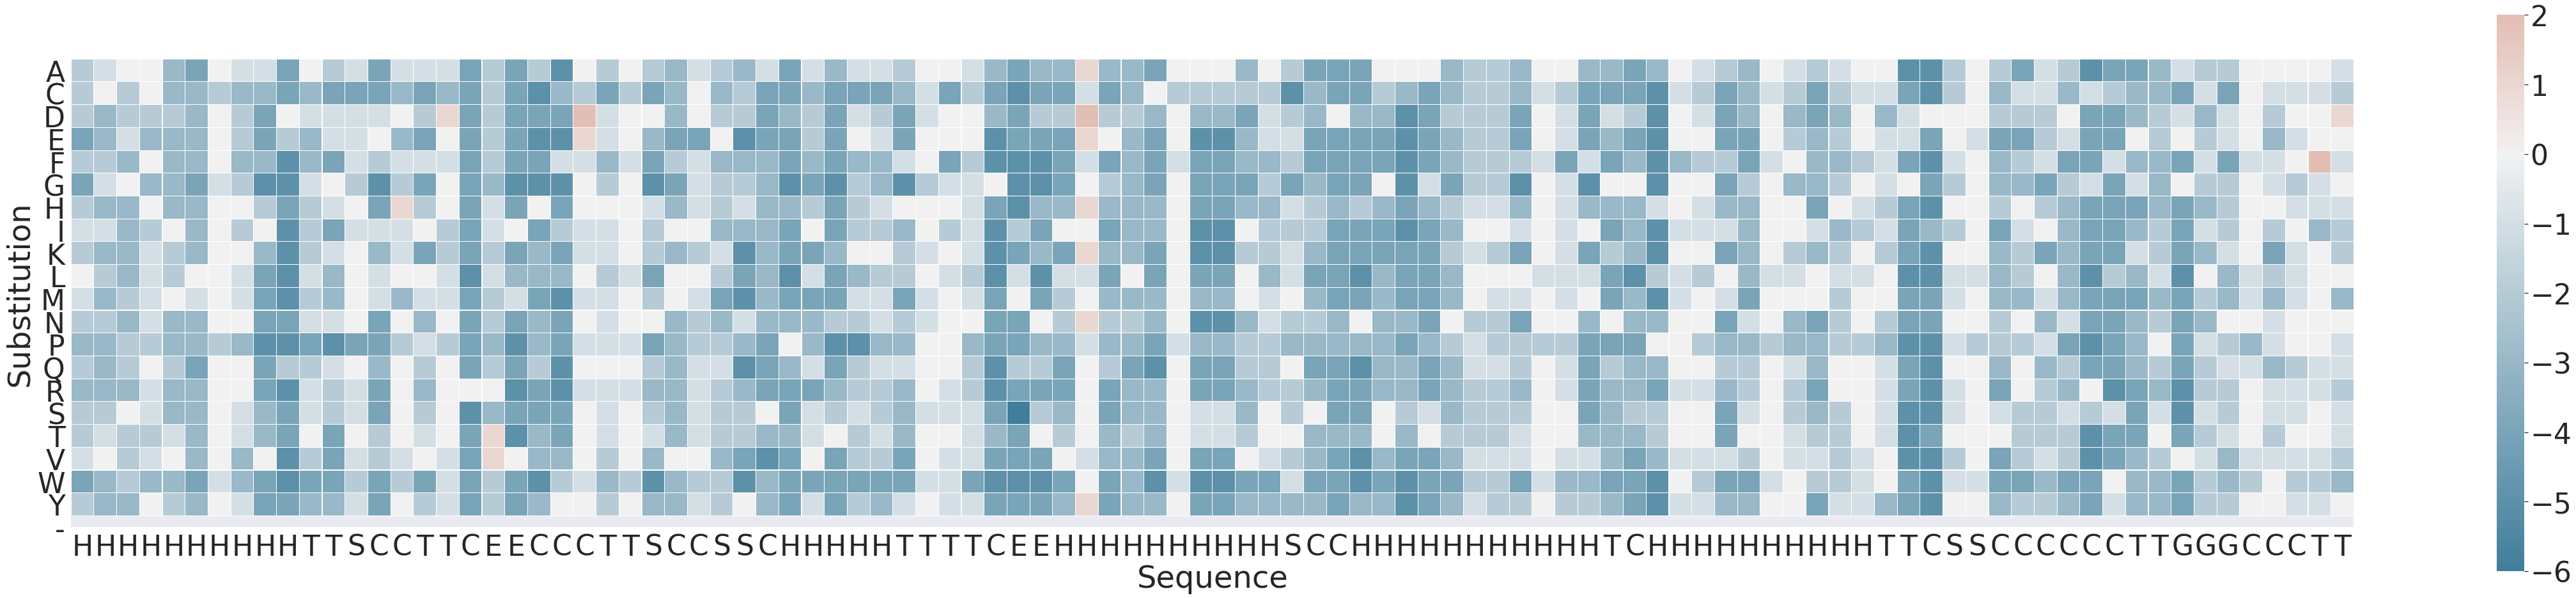

In [169]:
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.set(font_scale=4)
plt.figure(figsize = (80, 16))
sns.heatmap(-target.t()[:,50:150].numpy(), cmap = cmap, center = 0, xticklabels = best_sse[50:150], yticklabels = AA+"-", 
           square=True, linewidths=.1)
plt.xlabel("Sequence")
plt.ylabel("Substitution")
plt.show()

In [138]:
sse3 = np.array([dssp_to_abc[x] for x in best_sse])
sse8 = np.array([x for x in best_sse])

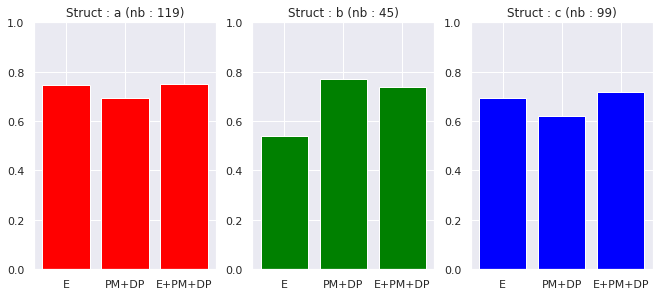

In [143]:
rho_e = []
rho_s = []
rho_b = []
colors = ["red", "green", "blue"]
for x in "abc":
    idx = np.where(sse3 == x)[0]
    if len(idx) == 0:
        rho_e.append(0)
        rho_s.append(0)
        rho_b.append(0)
        continue

    t = target[idx].flatten()
    e = heatmap_edca[idx].flatten()
    s = heatmap_ssqa[idx].flatten()
    b = heatmap_both[idx].flatten()
    rho_e.append(balanced_accuracy_score(t.int(),(e>thr_e).int()))
    rho_s.append(balanced_accuracy_score(t.int(),(s>thr_s).int()))
    rho_b.append(balanced_accuracy_score(t.int(),(b>thr_b).int()))
rho = np.array([rho_e,rho_s,rho_b])

plt.figure(figsize = (15,10))
for i, c in enumerate("abc"):
    plt.subplot(2,4,i+1)
    plt.bar(range(3), rho[:,i], color = colors[i])
    plt.xticks(range(3), ["E", "PM+DP", "E+PM+DP"])
    plt.title(f"Struct : {c} (nb : {len(np.where(sse3 == c)[0])})")
    plt.ylim(0,1)
plt.show()

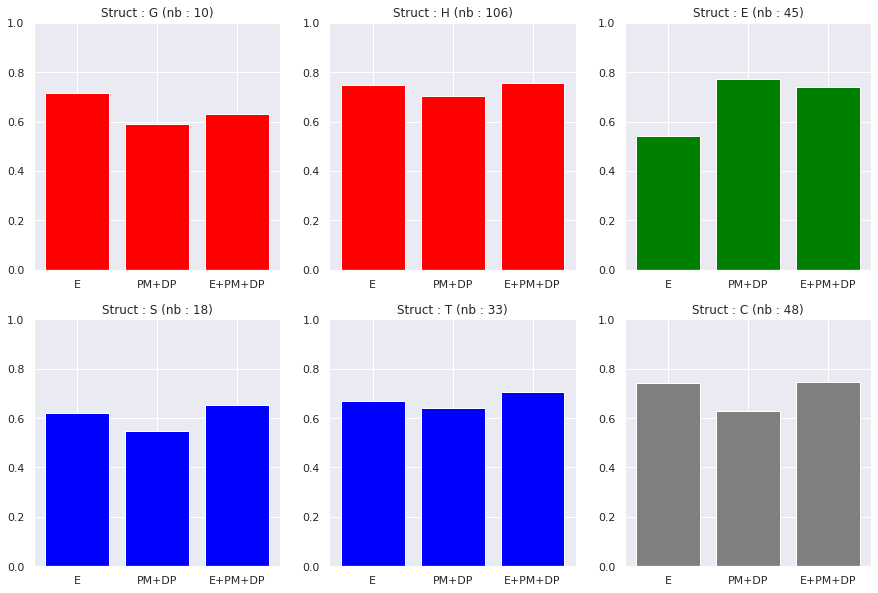

In [146]:
rho_e = []
rho_s = []
rho_b = []
colors = ["red", "red", "red", "green", "green", "blue", "blue", "gray"]
i = 0
for x in dssp_codes.keys():
    
    idx = np.where(sse8 == x)[0]
    if len(idx) == 0:
        rho_e.append(0)
        rho_s.append(0)
        rho_b.append(0)
        continue

    t = target[idx].flatten()
    e = heatmap_edca[idx].flatten()
    s = heatmap_ssqa[idx].flatten()
    b = heatmap_both[idx].flatten()
    rho_e.append(balanced_accuracy_score(t.int(),(e>thr_e).int()))
    rho_s.append(balanced_accuracy_score(t.int(),(s>thr_s).int()))
    rho_b.append(balanced_accuracy_score(t.int(),(b>thr_b).int()))
rho = np.array([rho_e,rho_s,rho_b])

plt.figure(figsize = (15,10))
j = 1
for i, c in enumerate(dssp_codes.keys()):
    if i == 3 or i ==2:
        continue
    plt.subplot(2,3,j)
    plt.bar(range(3), rho[:,i], color = colors[i])
    plt.xticks(range(3), ["E", "PM+DP", "E+PM+DP"])
    plt.title(f"Struct : {c} (nb : {len(np.where(sse8 == c)[0])})")
    plt.ylim(0,1)
    j+=1
plt.show()